In [ ]:
!sudo apt update && apt install xvfb && pip3 install pyvirtualdisplay && pip install pyvirtualdisplay
!sudo pip install pyvirtualdisplay

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,381 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [47.7 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 http://security.ubuntu.com/ubu

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

In [ ]:
# 필요한 라이브러리 호출
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count # 무한루프 사용 목적
from PIL import Image # 이미지 처리 목적

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

env = gym.make('CartPole-v1').unwrapped # CartPole이라는 강화 학습 환경
plt.ion()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
# 리플레이 메모리
Transition = namedtuple('Transition', # 하나의 경험을 저장
                        ('state', 'action', 'next_state', 'reward')) # 총 4가지의 정보 저장

class ReplayMemory(object):
    def __init__(self, capacity): # 초기화
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args): # 경험 저장
        if len(self.memory) < self.capacity:
            self.memory.append(None) # 메모리에 빈 부분이 남아있으면 공간 추기
        self.memory[self.position] = Transition(*args) # 현재 위치에 새로운 경험 저장
        self.position = (self.position + 1) % self.capacity # 오래된 데이터 덮어씀

    def sample(self, batch_size): # 배치 샘플링 -> 랜덤하게 batch_size만큼 반환함
        return random.sample(self.memory, batch_size)

    def __len__(self): # 길이 반환(현재 저장된 경험의 수)
        return len(self.memory)

In [ ]:
# DQN 모델 네트워크
class DQN(nn.Module):
    def __init__(self, h, w, outputs): # 초기화
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2) # 합성곱 & 배치 정규화 계층 정의
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        def conv2d_size_out(size, kernel_size = 5, stride = 2): # 출력층 크기 계산
            return (size - (kernel_size - 1) - 1) // stride  + 1

        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32 # 선형 계층 입력이 합성곱층의 출력과 입력 이미지의 크기에 따라 달라짐
        self.head = nn.Linear(linear_input_size, outputs) # 출력층 정의

    def forward(self, x): # 순전파 가정
        x = F.relu(self.bn1(self.conv1(x))) # 합성곱 연산 -> 배치 정규화 & RELU 활성화 함수 적용
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1)) # 다음 행동 결정

In [ ]:
# pyglet 패키지 설치(다양한 이미지 변환 쉽게 처리하도록 함)
!pip install pyglet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.1/962.1 kB 39.6 MB/s eta 0:00:00


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 3s (3,556 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126772 files and dire

/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning

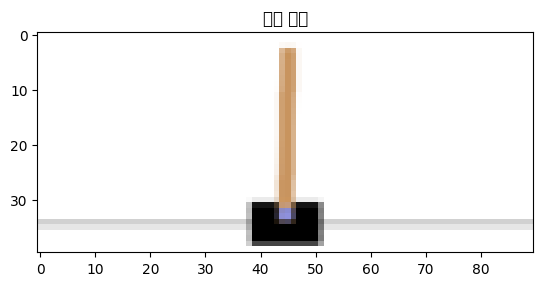

In [ ]:
# 이미지 추출 및 전처리 과정
import pyglet
from pyvirtualdisplay import Display # 코랩에서는 가상의 display를 생성 필요함
display = Display(visible=False, size=(400, 300))
display.start()

# 이미지 크기, 텐서 변환
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.BICUBIC), # 40 X 40 크기로 resizing
                    T.ToTensor()]) # 다시 PyTorch 텐서로 변환

def get_cart_location(screen_width): # 카트의 위치를 계산하는 함수
    world_width = env.x_threshold * 2
    scale = screen_width / world_width # 화면상의 비율
    return int(env.state[0] * scale + screen_width / 2.0)  # 카트의 중간 위치

def get_screen(): # 화면을 캡처 & 전처리하는 함수
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)] # 카트가 있는 부분을 잘라냄
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)

    if cart_location < view_width // 2: # 카트가 출력 화면의 아래쪽 중앙 위치 -> 필요없는 위쪽 아래쪽 제거해줌
        slice_range = slice(view_width) # slice : 데이터 중 일부를 잘라 가져올 때
    elif cart_location > (screen_width - view_width // 2): # 카트가 오른쪽 끝에 가까울 경우
        slice_range = slice(-view_width, None)
    else: # 카트가 화면 중앙에 있을 경우
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # 정규화
    screen = screen[:, :, slice_range] # 카트가 화면의 중간 부분에 위치하도록 가장자리 제거
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255 # float : 실수형 변환    # 정규화
        screen = screen[:, :, slice_range] # 카트가 화면의 중간 부분에 위치하도록 가장자리 제거
            screen = np.ascontiguousarray(screen, dtype=np.float32) / 255 # float : 실수형 변환
    screen = torch.from_numpy(screen)

    # 이미지 변환(출력 크기 조정, 배치 차원 추가)
    return resize(screen).unsqueeze(0).to(device)

# 화면 초기화, 화면 출력
env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none') # permute : transpose와 비슷함 -> 차원을 바꿔줌
plt.title('화면 예시')
plt.show()

In [ ]:
# 모델 객체화 및 손실함수 정의
BATCH_SIZE = 128
GAMMA = 0.999 # 할인율
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200 # 탐색률 감소 속도
TARGET_UPDATE = 10 # 타겟 네트워크 업데이트 주기
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape
n_actions = env.action_space.n # action에 대한 횟수

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict()) # load_state_dict : 모델의 파라미터값 채워옴
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters()) # 옵티마이저 설정
memory = ReplayMemory(10000) # 리플레이 메모리 설정

steps_done = 0

def select_action(state): # 액션 선택 함수
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold: # 탐험 경우
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1) # 각 행에서 가장 큰 열값 반환
    else: # 활용 경우
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

episode_durations = []

/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


In [ ]:
# 모델의 옵티마이저 정의
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool) # 게임의 상태 계산
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch) # Q(st, at) 값
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch # V(s(t+1)) 값

    # 오차 계산(L1 + L2)
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()

    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [ ]:
# 모델 학습
num_episodes = 50

for i_episode in range(num_episodes): # 에피소드 반복
    env.reset() # 환경과 상태 초기화
    last_screen = get_screen() # 현재의 화면 받아옴
    current_screen = get_screen()
    state = current_screen - last_screen # 상태 : 두 화면의 차이

    for t in count(): # 타임스텝 반복 -> 에피소드가 끝날 때까지 반복
        action = select_action(state) # 현재 상태에 대한 액션 선택, 실행
        # env.step now returns 5 values, so we need to unpack them accordingly
        _, reward, done, _, _ = env.step(action.item()) # 선택한 액션을 환경에 전달, 그에 대한 결과 받음
        reward = torch.tensor([reward], device=device)

        # 상태 업데이트 및 리플레이 메모리 저장
        last_screen = current_screen
        current_screen = get_screen()

        if not done: # 새로운 상태
            next_state = current_screen - last_screen
        else:
            next_state = None

        memory.push(state, action, next_state, reward)
        state = next_state # 다음 state로 이동

        # 모델 최적화
        optimize_model()
        # 에피소드 종료 처리
        if done:
            episode_durations.append(t + 1)
            break
    # 타겟 네트워크 업데이트
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict()) # 타깃 업데이트

print('종료')
# env.render()
env.close()
plt.show()

/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


종료


In [ ]:
# 몬테카를로 트리 검색을 적용한 틱택토 게임 구현하기

In [ ]:
# 보드 생성
boarder = {'1': ' ' , '2': ' ' , '3': ' ' ,
            '4': ' ' , '5': ' ' , '6': ' ' ,
            '7': ' ' , '8': ' ' , '9': ' ' }

board_keys = []

for key in boarder:
    board_keys.append(key)

In [ ]:
# 화면 출력 함수 정의(1 ~ 9 사이의 숫자)
def visual_Board(board_num):
    print(board_num['1'] + '|' + board_num['2'] + '|' + board_num['3'])
    print('-+-+-')
    print(board_num['4'] + '|' + board_num['5'] + '|' + board_num['6'])
    print('-+-+-')
    print(board_num['7'] + '|' + board_num['8'] + '|' + board_num['9'])

In [ ]:
# 보드 이동 함수 정의(에이전트가 보드 이동함)
def game(): # 플레이어의 보드 이동 함수
    turn = 'X'
    count = 0

    for i in range(8):
        visual_Board(boarder)
        print("당신 차례입니다," + turn + ". 어디로 이동할까요?")
        move = input()
        if boarder[move] == ' ':
            boarder[move] = turn
            count += 1
        else:
            print("이미 채워져있습니다.\n어디로 이동할까요?")
            continue

        if count >= 5: # 플레이어 X or Y가 5번 이동 후 이겼는지 확인함
            if boarder['1'] == boarder['2'] == boarder['3'] != ' ': # 상단에 1, 2, 3 채워짐
                visual_Board(boarder)
                print("\n게임 종료.\n")
                print(" ---------- " +turn + "가 승리했습니다. -----------")
                break

            elif boarder['4'] == boarder['5'] == boarder['6'] != ' ': # 중간에 4, 5, 6 채워짐
                visual_Board(boarder)
                print("\n게임 종료.\n")
                print(" ---------- " +turn + "가 승리했습니다. -----------")
                break

            elif boarder['7'] == boarder['8'] == boarder['9'] != ' ': # 하단에 7, 8, 9 채워짐
                visual_Board(boarder)
                print("\n게임 종료.\n")
                print(" ---------- " +turn + "가 승리했습니다. -----------")
                break

            elif boarder['1'] == boarder['4'] == boarder['7'] != ' ': # 왼쪽에 1, 4, 7 채워짐
                visual_Board(boarder)
                print("\n게임 종료.\n")
                print(" ---------- " +turn + "가 승리했습니다. -----------")
                break

            elif boarder['2'] == boarder['5'] == boarder['8'] != ' ': # 중간에 2, 5, 8 채워짐
                visual_Board(boarder)
                print("\n게임 종료.\n")
                print(" ---------- " +turn + "가 승리했습니다. -----------")
                break

            elif boarder['3'] == boarder['6'] == boarder['9'] != ' ': # 오른쪽에 3, 6, 9 채워짐
                visual_Board(boarder)
                print("\n게임 종료.\n")
                print(" ---------- " +turn + "가 승리했습니다. -----------")
                break

            elif boarder['1'] == boarder['5'] == boarder['9'] != ' ': # 대각선 1, 5, 9 채워짐
                visual_Board(boarder)
                print("\n게임 종료.\n")
                print(" ---------- " +turn + "가 승리했습니다. -----------")
                break

            elif boarder['3'] == boarder['5'] == boarder['7'] != ' ': # 대각선 3, 5, 7 채워짐
                visual_Board(boarder)
                print("\n게임 종료.\n")
                print(" ---------- " +turn + "가 승리했습니다. -----------")
                break

        if count == 9: # X, Y 누구도 이기지 않고 보드 꽉 찬 경우 동점
            print("\n게임 종료.\n")
            print("동점입니다")


        if turn =='X': # X 다음은 Y 차례
            turn = 'Y'
        else: # Y 다음은 X 차례
            turn = 'X'

if __name__ == "__main__":
    game()

 | | 
-+-+-
 | | 
-+-+-
 | | 
당신 차례입니다,X. 어디로 이동할까요?
6
 | | 
-+-+-
 | |X
-+-+-
 | | 
당신 차례입니다,Y. 어디로 이동할까요?
5
 | | 
-+-+-
 |Y|X
-+-+-
 | | 
당신 차례입니다,X. 어디로 이동할까요?
7
 | | 
-+-+-
 |Y|X
-+-+-
X| | 
당신 차례입니다,Y. 어디로 이동할까요?
9
 | | 
-+-+-
 |Y|X
-+-+-
X| |Y
당신 차례입니다,X. 어디로 이동할까요?
1
X| | 
-+-+-
 |Y|X
-+-+-
X| |Y
당신 차례입니다,Y. 어디로 이동할까요?
3
X| |Y
-+-+-
 |Y|X
-+-+-
X| |Y
당신 차례입니다,X. 어디로 이동할까요?
5
이미 채워져있습니다.
어디로 이동할까요?
X| |Y
-+-+-
 |Y|X
-+-+-
X| |Y
당신 차례입니다,X. 어디로 이동할까요?
2
